In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import warnings 
warnings.filterwarnings("ignore")

<h2> Order of Trend Prediction Techniques performed in the notebook<br>
1. Estimating and Predicting Trend with Polynommial Regression <br>
2. Predicting Trend with Holt Smoothing Techniques <br>
3. Predicting the given data (not trend) with Holt Smoothing Techniques</h2>

<h2> Importing Data for Bengaluru Urban and indexing by dates <h2>

In [139]:
data = pd.read_csv('BengU_Finalmegadata.csv', parse_dates=['date'], index_col='date')

In [140]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [141]:
data.head()

,District_Name,Todays_Positives,Total_Positives,Todays_Discharges,Total_Discharges,Total_Active_Cases,Todays_Covid_Deaths,Total_Covid_Deaths,Non_Covid_Deaths
date,,,,,,,,,
2020-07-01,Bengaluru Urban,735.0,5290.0,0.0,543.0,4649.0,NaN,97.0,1.0
2020-07-02,Bengaluru Urban,889.0,6179.0,30.0,573.0,5505.0,NaN,100.0,1.0
2020-07-03,Bengaluru Urban,994.0,7173.0,197.0,770.0,6297.0,NaN,105.0,1.0
2020-07-04,Bengaluru Urban,1172.0,8345.0,195.0,965.0,7250.0,NaN,129.0,1.0
2020-07-05,Bengaluru Urban,1235.0,9580.0,302.0,1267.0,8167.0,NaN,145.0,1.0


In [142]:
daily_pos = data.Todays_Positives

In [143]:
# From 20-02-2021, the selection of date is random
daily_pos = daily_pos.iloc[200:]

In [144]:
daily_pos

date
2021-02-20     278.0
2021-02-21     248.0
2021-02-22     181.0
2021-02-23     240.0
2021-02-24     174.0
               ...  
2021-05-30    4734.0
2021-05-31    3992.0
2021-06-01    3418.0
2021-06-02    4095.0
2021-06-03    3533.0
Name: Todays_Positives, Length: 101, dtype: float64

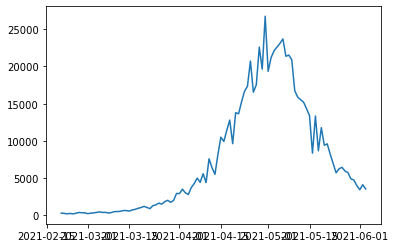

In [145]:
plt.plot(daily_pos)

<h2> Creating a Function for Dickey Fuller Test Results <h2>

In [146]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, period = 0):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(period).mean()
    rolstd = timeseries.rolling(period).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('\nResults of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

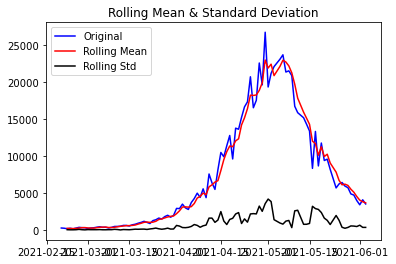


Results of Dickey-Fuller Test:
Test Statistic                 -2.441005
p-value                         0.130496
#Lags Used                      8.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64


In [147]:
# ADF test results for Daily Positives, with rolling mean for 3 days
test_stationarity(daily_pos,3)

<h2> We see that the given time series data is not Stationary<h2>

In [148]:
# Taking log of the data values in columns 'Todays_Positive'
ts_log = pd.Series(np.log(daily_pos))

In [149]:
# Differencing the log data twice
ts_log_diff = ts_log.diff(1)
ts_log_diff = ts_log_diff.diff(2)
ts_log_diff.dropna(inplace = True)

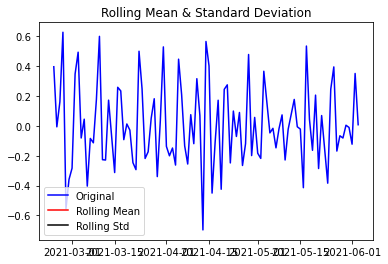


Results of Dickey-Fuller Test:
Test Statistic                -8.012638e+00
p-value                        2.180590e-12
#Lags Used                     7.000000e+00
Number of Observations Used    9.000000e+01
Critical Value (1%)           -3.505190e+00
Critical Value (5%)           -2.894232e+00
Critical Value (10%)          -2.584210e+00
dtype: float64


In [150]:
# Testing the stationarity of one time differenced data
test_stationarity(pd.Series(ts_log_diff))

<h2>ts_log_diff (differenced twice) is stationary by ADF Test as shown above<h2>

In [151]:
# Decomposing the time series
# The given time series becomes stationary when differenced atleast twice, so we give period = 2
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_pos, period = 2)

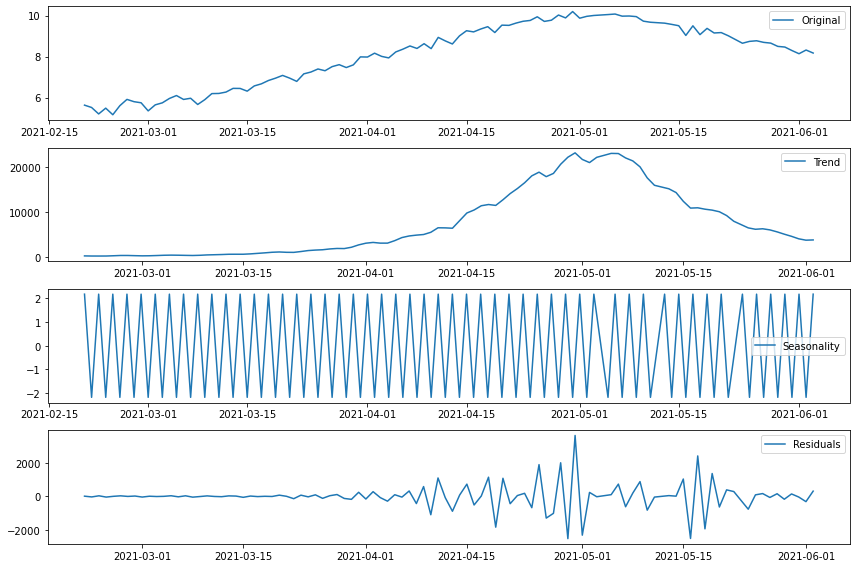

In [152]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
figure(figsize = (12, 8))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


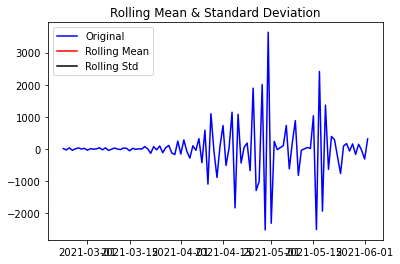


Results of Dickey-Fuller Test:
Test Statistic                -7.379465e+00
p-value                        8.548134e-11
#Lags Used                     6.000000e+00
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


In [153]:
# Checking the residual value
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)


<h2> Residue value is also Stationary <br>
We now perform ARIMA model on Residue value<br>
After performing ARIMA on Residue value, we add the trend and seasonal values back to it to get the predicted Time Series</h2>


In [154]:
# Plotting the ACF and PACF of residuals
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_decompose, nlags=20)
lag_pacf = pacf(ts_decompose, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

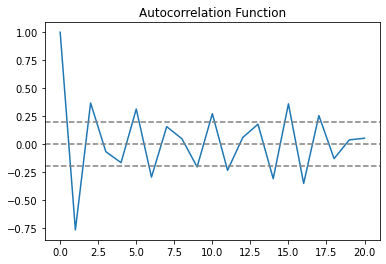

In [155]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

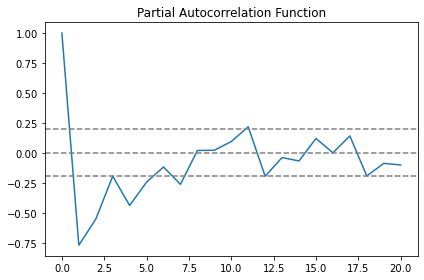

In [156]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

<h2> For the above two plots we choose the following values for (p,q,d) = (1,1,0) <br>
The values are chosen based on the integer value of lag at which the function crosses the first horizontal line above the y = 0 </h2>

<h2> Auto ARIMA <br>
We perform Auto ARIMA to check better parameters for ARIMA model<br></h2>

In [157]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df_auto = ts_decompose
model_auto = pm.auto_arima(ts_decompose.values, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1615.768, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1529.683, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1496.293, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1494.592, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1476.334, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1469.019, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1476.262, Time=0.18 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1470.626, Time=0.46 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1476.496, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1470.992, Time=0.26 sec

Best model:  ARIMA(4,0,1)(0,0,0)[0]          
Total fit time: 2.194 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
M

<h2> We see that the values (p,d,q) = (4,0,1) for the parameters are good choice for the forecasting with help of ARIMA, so we give these values to the model</h2>

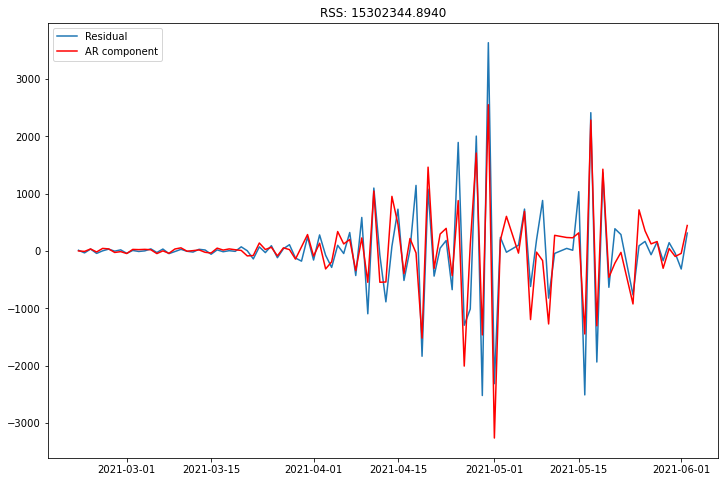

In [158]:
from statsmodels.tsa.arima_model import ARIMA
# AR model
figure(figsize = (12, 8))
model_AR = ARIMA(ts_decompose, order=(4, 0, 0))  
results_AR = model_AR.fit(disp=-1)  
plt.plot(ts_decompose, label = 'Residual')
plt.plot(results_AR.fittedvalues, color='red', label = 'AR component')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_decompose)**2))
plt.legend(loc = 'upper left')

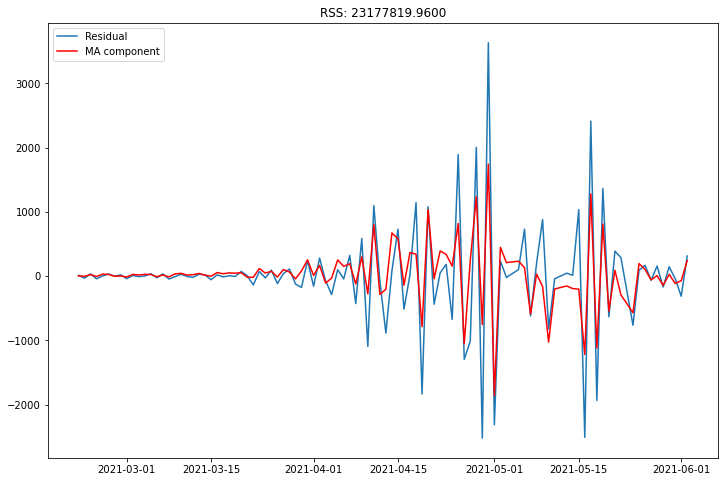

In [159]:
#MA model
figure(figsize = (12, 8))
model_MA = ARIMA(ts_decompose, order=(0, 0, 1))  
results_MA = model_MA.fit(disp=-1)  
plt.plot(ts_decompose, label = 'Residual')
plt.plot(results_MA.fittedvalues, color='red', label = 'MA component')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_decompose)**2))
plt.legend(loc = 'upper left')

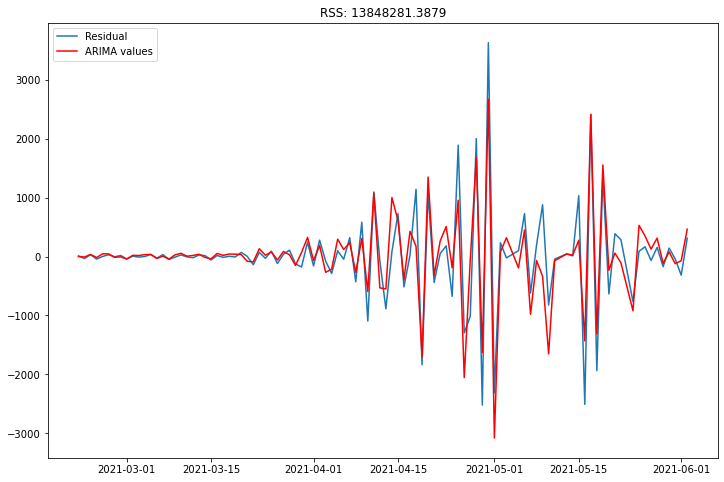

In [160]:
model_ARIMA = ARIMA(ts_decompose, order=(4, 0, 1))  
results_ARIMA = model_ARIMA.fit(disp=-1)  
figure(figsize = (12, 8))
plt.plot(ts_decompose, label = 'Residual')
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'ARIMA values')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_decompose)**2))
plt.legend(loc= 'upper left')

In [161]:
# Storing forecasting and confidence interval (95%) by the model for next 15 days
fc_res, sc_res, conf_res = results_ARIMA.forecast(15, alpha = 0.05)

In [162]:
res = pd.concat([pd.Series(fc_res), pd.Series(conf_res[:, 0]), pd.Series(conf_res[:, 1])], axis = 1)

In [163]:
res

,0,1,2
0,-59.106910,-792.127361,673.913542
1,31.331414,-1312.501318,1375.164146
2,-15.800836,-1510.796374,1479.194702
3,-83.267387,-1608.176613,1441.641840
4,97.167752,-1434.010416,1628.345920
5,-47.059564,-1585.760291,1491.641164
6,33.494469,-1538.335166,1605.324104
7,-14.770542,-1608.689982,1579.148897
8,-16.009887,-1620.403409,1588.383636
9,28.134839,-1579.880578,1636.150256


In [164]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2021-02-21     0.794568
2021-02-22    -7.366922
2021-02-23    35.883991
2021-02-24   -16.596591
2021-02-25    46.305905
dtype: float64


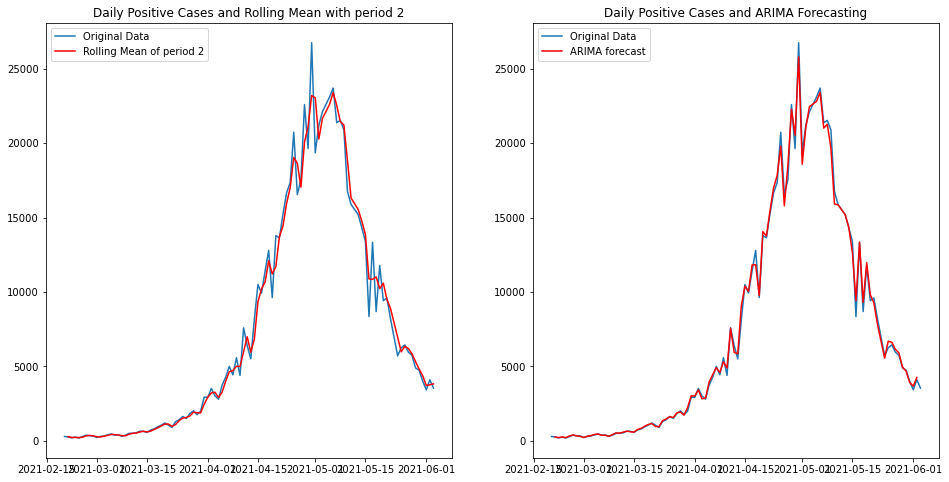

In [165]:
# We now plot the original and predicted time series after adding the trend and seaonality

fig, axes = plt.subplots(1,2, figsize = (16, 8))
axes[0].plot(daily_pos, label = 'Original Data')
axes[0].plot(daily_pos.rolling(2).mean(), color = 'red', label = 'Rolling Mean of period 2')
axes[0].title.set_text('Daily Positive Cases and Rolling Mean with period 2')
axes[0].legend(loc = 'upper left')

axes[1].plot(daily_pos, label = 'Original Data')
axes[1].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA forecast')
axes[1].title.set_text('Daily Positive Cases and ARIMA Forecasting')
axes[1].legend(loc = 'upper left')


<h2> Using differenced log value </h2>

In [166]:
df_log = ts_log_diff
model = pm.auto_arima(ts_log_diff.values, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27.466, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26.589, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2.635, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5.185, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-16.818, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10.625, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-16.263, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10.592, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-15.479, Time=0.30 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.368 seconds
                               SARIMAX Results                                
Dep. Variable:                      y  

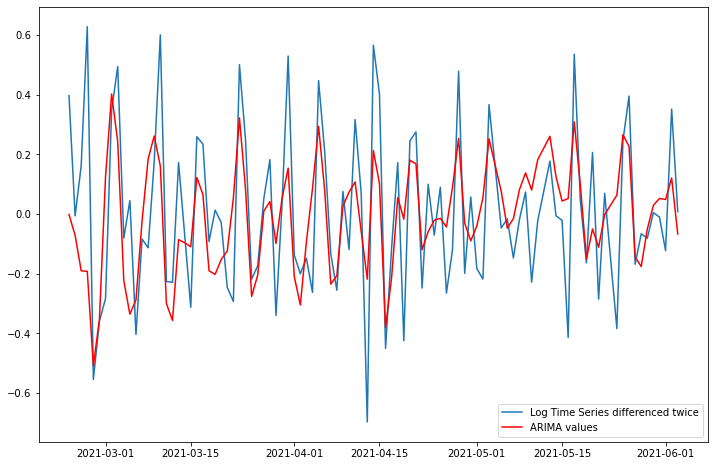

In [167]:
model_log = ARIMA(ts_log_diff, order=(2, 0, 1))  
results_ARIMA_log = model_log.fit(disp=-1)  
figure(figsize = (12, 8))
plt.plot(ts_log_diff, label = 'Log Time Series differenced twice')
plt.plot(results_ARIMA_log.fittedvalues, color='red', label = 'ARIMA values')
plt.legend(loc= 'lower right')

In [168]:
# Taking exponential of the log values
exp = pd.Series(np.exp(results_ARIMA_log.fittedvalues))

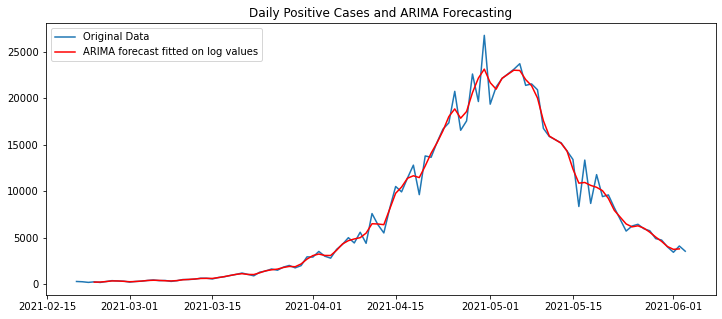

In [169]:
figure(figsize =  (12, 5))
plt.plot(daily_pos, label = 'Original Data')
plt.plot(exp + trend + seasonal, color = 'red', label = 'ARIMA forecast fitted on log values')
plt.title('Daily Positive Cases and ARIMA Forecasting')
plt.legend(loc = 'upper left')


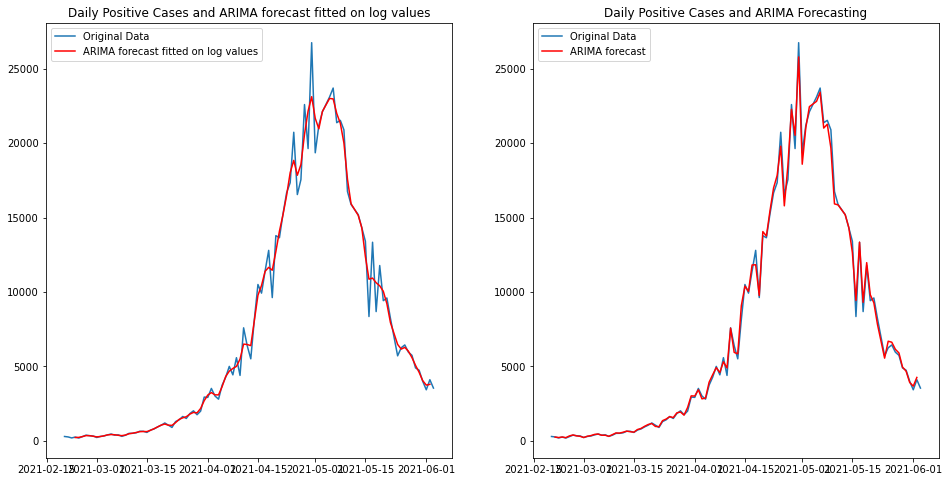

In [170]:
# Comparing log fitted values and non log fitted values both obtained from ARIMA
fig_1, axes_1 = plt.subplots(1,2, figsize = (16, 8))
axes_1[0].plot(daily_pos, label = 'Original Data')
axes_1[0].plot(exp + trend + seasonal, color = 'red', label = 'ARIMA forecast fitted on log values')
axes_1[0].title.set_text('Daily Positive Cases and ARIMA forecast fitted on log values')
axes_1[0].legend(loc = 'upper left')

axes_1[1].plot(daily_pos, label = 'Original Data')
axes_1[1].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA forecast')
axes_1[1].title.set_text('Daily Positive Cases and ARIMA Forecasting')
axes_1[1].legend(loc = 'upper left')

<h2>We see that ARIMA forecast fitted on non log valued data (Figure on RHS) takes into the account peaks better than ARIMA fitted on log values and rolling average with period 2</h2>

<h2> Seasonality<br>
We store the Seasonality values for next 15 days required for prediction in a dataframe </h2>

In [171]:
seasonal_copy = seasonal.copy()

In [172]:
seasonal_copy.head(15)

date
2021-02-20    2.180459
2021-02-21   -2.180459
2021-02-22    2.180459
2021-02-23   -2.180459
2021-02-24    2.180459
2021-02-25   -2.180459
2021-02-26    2.180459
2021-02-27   -2.180459
2021-02-28    2.180459
2021-03-01   -2.180459
2021-03-02    2.180459
2021-03-03   -2.180459
2021-03-04    2.180459
2021-03-05   -2.180459
2021-03-06    2.180459
Name: seasonal, dtype: float64

In [173]:
seasonal_copy = seasonal_copy.head(15)

In [174]:
seasonal_copy

date
2021-02-20    2.180459
2021-02-21   -2.180459
2021-02-22    2.180459
2021-02-23   -2.180459
2021-02-24    2.180459
2021-02-25   -2.180459
2021-02-26    2.180459
2021-02-27   -2.180459
2021-02-28    2.180459
2021-03-01   -2.180459
2021-03-02    2.180459
2021-03-03   -2.180459
2021-03-04    2.180459
2021-03-05   -2.180459
2021-03-06    2.180459
Name: seasonal, dtype: float64

In [175]:
# Creating seasonal_copy Series with required dates as index
seasonal_copy_1= pd.Series(seasonal_copy.values)

In [176]:
seasonal_copy_1.index = pd.date_range('2021-06-03', '2021-06-17')

In [177]:
seasonal_copy_1

2021-06-03    2.180459
2021-06-04   -2.180459
2021-06-05    2.180459
2021-06-06   -2.180459
2021-06-07    2.180459
2021-06-08   -2.180459
2021-06-09    2.180459
2021-06-10   -2.180459
2021-06-11    2.180459
2021-06-12   -2.180459
2021-06-13    2.180459
2021-06-14   -2.180459
2021-06-15    2.180459
2021-06-16   -2.180459
2021-06-17    2.180459
Freq: D, dtype: float64

In [178]:
trend.dropna(inplace = True)

In [179]:
df_trend = trend
model_trend_auto = pm.auto_arima(trend.values, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # not differencing
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_trend_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2113.222, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2046.984, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.310 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:                        SARIMAX   Log Likelihood               -1021.492
Date:                Wed, 04 Aug 2021   AIC                           2046.984
Time:                        21:01:54   BIC                       

<h2> Estimating and Predicting Trend with Polynomial Regression </h2>

R2 Score for plot 0: 0.0



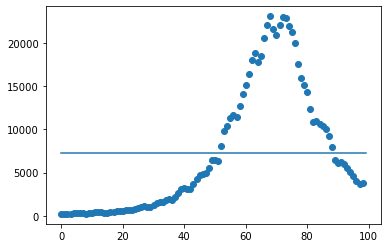



R2 Score for plot 1: 0.4223715781306574



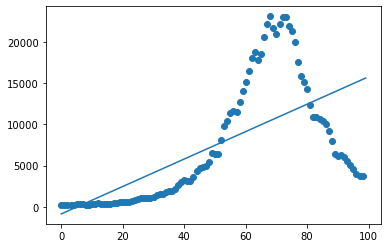



R2 Score for plot 2: 0.5257068324018385



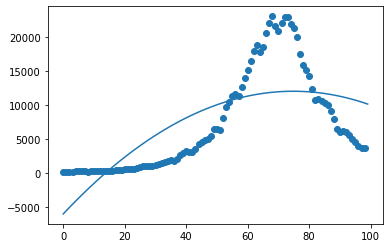



R2 Score for plot 3: 0.8580652982502367



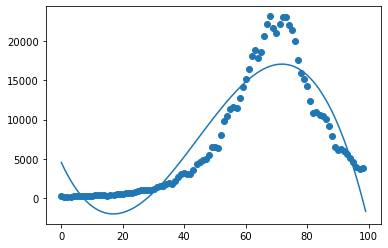



R2 Score for plot 4: 0.8785504743679263



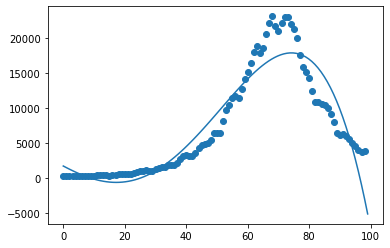



R2 Score for plot 5: 0.9311461529976486



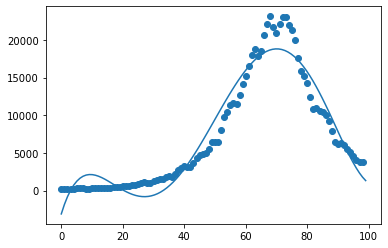



R2 Score for plot 6: 0.9737998955981296



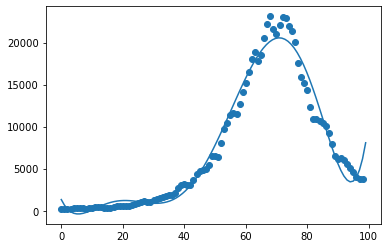



R2 Score for plot 7: 0.9738005908189993



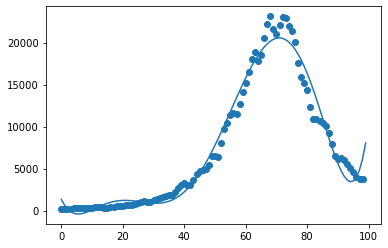



R2 Score for plot 8: 0.9861673828665806



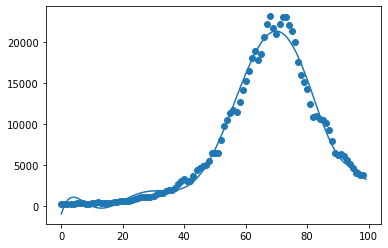



R2 Score for plot 9: 0.9907384792732522



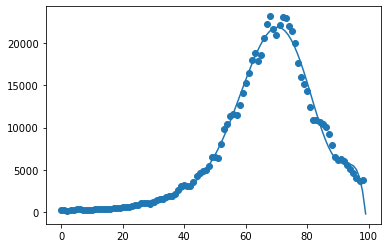

In [180]:
import numpy
from sklearn.metrics import r2_score

for i in range(10):
    poly = np.poly1d(np.polyfit(np.arange(0,len(trend.values),1), trend.values, i))
    line = np.linspace(0, len(trend.values), len(trend.values))
    print(f'R2 Score for plot {i}: {r2_score(trend.values, poly(np.arange(0,len(trend.values),1)))}\n')
    plt.scatter(np.arange(0,len(trend.values),1), trend.values)
    plt.plot(line, poly(line))
    plt.show()
    print('\n')

<h2> From the above plots we choose model fitted with Polynomial of degrees 8 and 9</h2>

In [181]:
poly_8 = np.poly1d(np.polyfit(np.arange(0,len(trend.values),1), trend.values, 8))
poly_9 = np.poly1d(np.polyfit(np.arange(0,len(trend.values),1), trend.values, 9))

# Predicitng for next 15 days
pred_8_15 = poly_8(np.arange(99,99+15,1))
pred_9_15 = poly_9(np.arange(99,99+15,1))

In [182]:
pred_8_15

array([   3211.25115811,    2211.54386222,     692.60185206,
         -1523.57049496,   -4647.2628008 ,   -8924.63193566,
        -14641.52420519,  -22127.55669309,  -31760.46816654,
        -43970.75014203,  -59246.56890099,  -78138.9894358 ,
       -101267.51249584, -129325.93609563, -163088.55303917])

In [183]:
# Adding the Forecasted residues, Trend and Seasonality for polynomial of degree 8
fc_8_15 = pred_8_15 + fc_res_15 + seasonal_15
low_conf_8_15 = conf_res_15[:,0] + pred_8_15 + seasonal_15
high_conf_8_15 = conf_res_15[:, 1] + pred_8_15 + seasonal_15

In [184]:
# Adding the Forecasted residues, Trend and Seasonality for polynomial of degree 9
fc_9_15 = pred_9_15 + fc_res_15 + seasonal_15
low_conf_9_15 = conf_res_15[:,0] + pred_9_15 + seasonal_15
high_conf_9_15 = conf_res_15[:, 1] + pred_9_15 + seasonal_15

In [185]:
# Storing the forecasts and confidence intervals in a dataframe
prediction_8_15 = pd.concat([pd.Series(fc_8_15), pd.Series(low_conf_8_15), pd.Series(high_conf_8_15)], axis = 1, ignore_index=True)
prediction_9_15 = pd.concat([pd.Series(fc_9_15), pd.Series(low_conf_9_15), pd.Series(high_conf_9_15)], axis = 1, ignore_index=True)
prediction_8_15.columns = ['forecast', 'low_conf', 'high_conf']
prediction_9_15.columns = ['forecast', 'low_conf', 'high_conf']
prediction_8_15.index = pd.date_range('2021-06-03','2021-06-17')
prediction_9_15.index = pd.date_range('2021-06-03','2021-06-17')

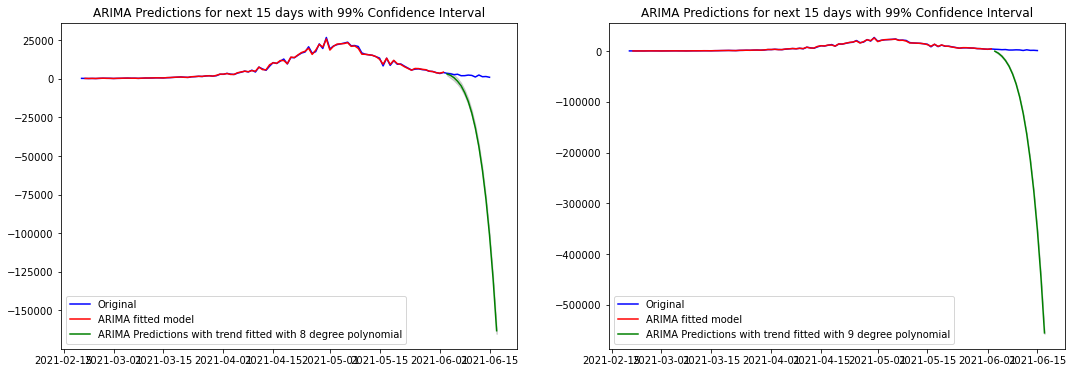

In [186]:
fig_new_1, ax_new = plt.subplots(1,2, figsize = (18, 6))
#figure(figsize = (12, 8))
ax_new[0].plot(data_new['Todays_Positives'].iloc[200:], color = 'blue',label = 'Original')
ax_new[0].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA fitted model')
ax_new[0].plot(prediction_8_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with 8 degree polynomial')
ax_new[0].fill_between(prediction_8_15.index, prediction_8_15.low_conf, prediction_8_15.high_conf, 
                 color='k', alpha=.15)
ax_new[0].legend(loc = 'lower left')
ax_new[0].title.set_text('ARIMA Predictions for next 15 days with 99% Confidence Interval')

#figure(figsize = (12, 8))
ax_new[1].plot(data_new['Todays_Positives'].iloc[200:], color = 'blue',label = 'Original')
ax_new[1].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA fitted model')
ax_new[1].plot(prediction_9_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with 9 degree polynomial')
ax_new[1].fill_between(prediction_9_15.index, prediction_9_15.low_conf, prediction_9_15.high_conf, 
                 color='k', alpha=.15)
ax_new[1].legend(loc = 'lower left')
ax_new[1].title.set_text('ARIMA Predictions for next 15 days with 99% Confidence Interval')

<h2> Using Holt Exponential Smoothing </h2>

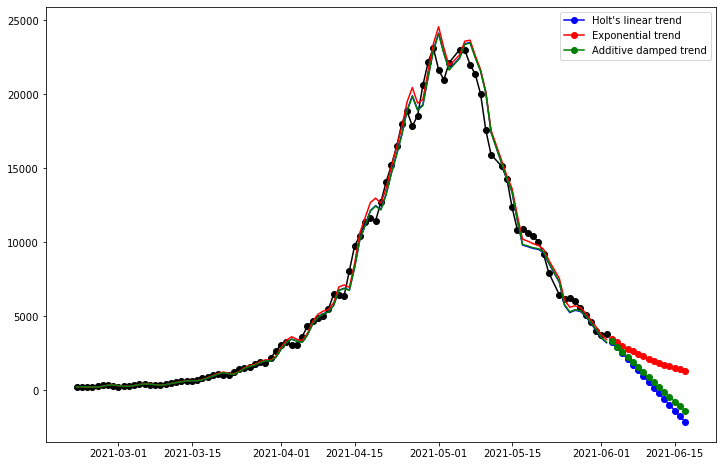

In [187]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings 
warnings.filterwarnings("ignore")

# Fitting Holt Techniques for different parameters(linear, exponential, additive damped) on trend values
fit1 = Holt(trend, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast1 = fit1.forecast(15).rename("Holt's linear trend")
fcast1.index = pd.date_range('2021-06-03','2021-06-17')

fit2 = Holt(trend, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast2 = fit2.forecast(15).rename("Exponential trend")
fcast2.index = pd.date_range('2021-06-03','2021-06-17')

fit3 = Holt(trend, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized = True)
fcast3 = fit3.forecast(15).rename("Additive damped trend")
fcast3.index = pd.date_range('2021-06-03','2021-06-17')

plt.figure(figsize=(12, 8))
plt.plot(trend, marker='o', color='black')
plt.plot(fit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(fit3.fittedvalues, color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [188]:
# Adding forecasted trend values with holt techniques, seasonality and ARIMA forecasted residues to get the original forecast
fc_holt_lin_15 = fc_res_15 + fcast1.values + seasonal_15
fc_holt_addamp_15 = fc_res_15 + fcast3.values + seasonal_15
fc_holt_exp_15 = fc_res_15 + fcast2.values + seasonal_15

low_conf_holt_lin_15 =  conf_res_15[:, 0] + fcast1.values + seasonal_15
low_conf_addamp_15 = conf_res_15[:, 0] + fcast3.values + seasonal_15
low_conf_exp_15 = conf_res_15[:, 0] + fcast2.values + seasonal_15

high_conf_holt_lin_15 =  conf_res_15[:, 1] + fcast1.values + seasonal_15
high_conf_addamp_15 = conf_res_15[:, 1] + fcast3.values + seasonal_15
high_conf_exp_15 = conf_res_15[:, 1] + fcast2.values + seasonal_15

In [189]:
# Storing the forecast in Dataframes
prediction_holt_lin_15 = pd.concat([pd.Series(fc_holt_lin_15), pd.Series(low_conf_holt_lin_15), pd.Series(high_conf_holt_lin_15)], axis = 1, ignore_index=True)
prediction_holt_addamp_15 = pd.concat([pd.Series(fc_holt_addamp_15), pd.Series(low_conf_addamp_15), pd.Series(high_conf_addamp_15)], axis = 1, ignore_index=True)
prediction_holt_exp_15 = pd.concat([pd.Series(fc_holt_exp_15), pd.Series(low_conf_exp_15), pd.Series(high_conf_exp_15)], axis = 1, ignore_index=True)

prediction_holt_lin_15.columns = ['forecast', 'low_conf', 'high_conf']
prediction_holt_addamp_15.columns = ['forecast', 'low_conf', 'high_conf']
prediction_holt_exp_15.columns = ['forecast', 'low_conf', 'high_conf']

prediction_holt_lin_15.index = pd.date_range('2021-06-03','2021-06-17')
prediction_holt_addamp_15.index = pd.date_range('2021-06-03','2021-06-17')
prediction_holt_exp_15.index = pd.date_range('2021-06-03','2021-06-17')

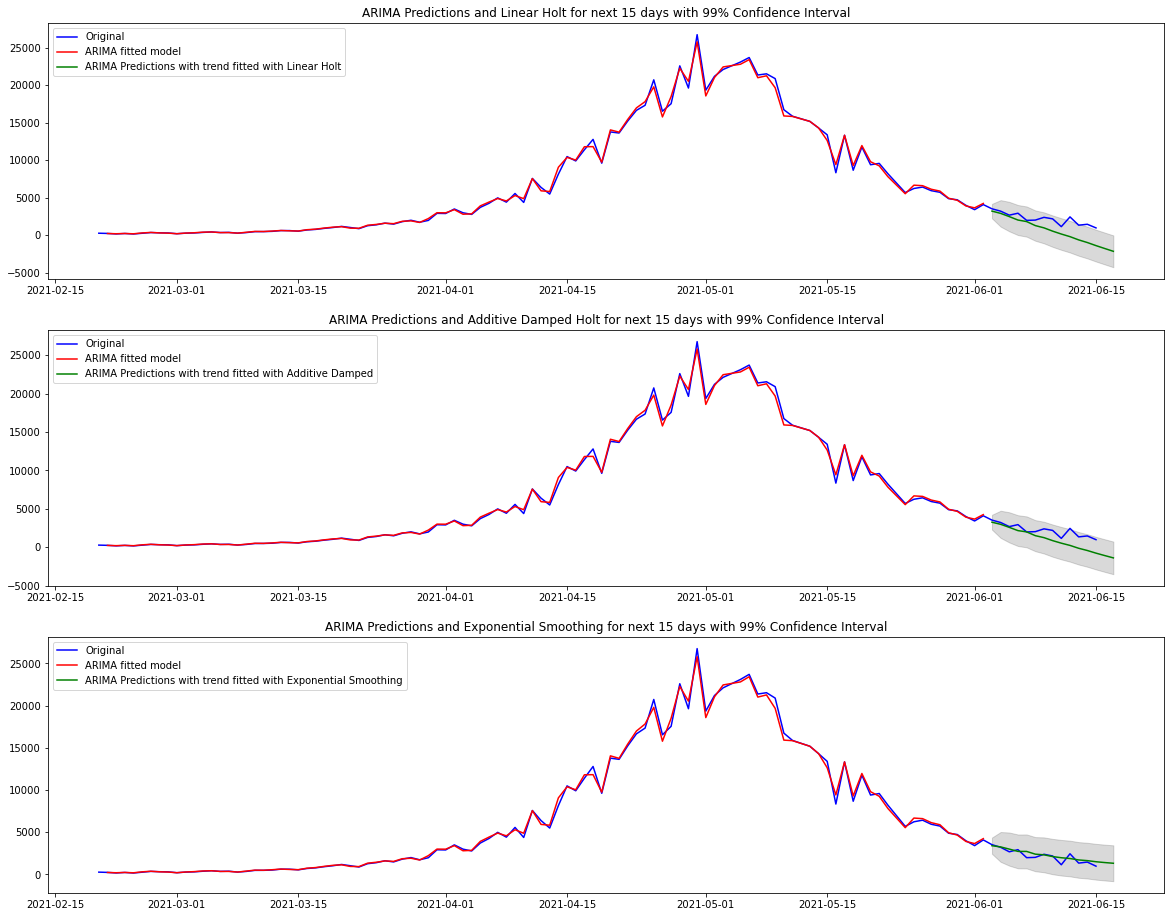

In [190]:
fig_holt, ax_holt = plt.subplots(3,1, figsize = (20, 16))
#figure(figsize = (12, 8))
ax_holt[0].plot(data_new['Todays_Positives'].iloc[200:], color = 'blue',label = 'Original')
ax_holt[0].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA fitted model')
ax_holt[0].plot(prediction_holt_lin_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with Linear Holt')
ax_holt[0].fill_between(prediction_holt_lin_15.index, prediction_holt_lin_15.low_conf, prediction_holt_lin_15.high_conf, 
                 color='k', alpha=.15)
ax_holt[0].legend(loc = 'upper left')
ax_holt[0].title.set_text('ARIMA Predictions and Linear Holt for next 15 days with 99% Confidence Interval')

#figure(figsize = (12, 8))
ax_holt[1].plot(data_new['Todays_Positives'].iloc[200:], color = 'blue',label = 'Original')
ax_holt[1].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA fitted model')
ax_holt[1].plot(prediction_holt_addamp_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with Additive Damped')
ax_holt[1].fill_between(prediction_holt_addamp_15.index, prediction_holt_addamp_15.low_conf, prediction_holt_addamp_15.high_conf, 
                 color='k', alpha=.15)
ax_holt[1].legend(loc = 'upper left')
ax_holt[1].title.set_text('ARIMA Predictions and Additive Damped Holt for next 15 days with 99% Confidence Interval')

ax_holt[2].plot(data_new['Todays_Positives'].iloc[200:], color = 'blue',label = 'Original')
ax_holt[2].plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA fitted model')
ax_holt[2].plot(prediction_holt_exp_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with Exponential Smoothing')
ax_holt[2].fill_between(prediction_holt_exp_15.index, prediction_holt_exp_15.low_conf, prediction_holt_exp_15.high_conf, 
                 color='k', alpha=.15)
ax_holt[2].legend(loc = 'upper left')
ax_holt[2].title.set_text('ARIMA Predictions and Exponential Smoothing for next 15 days with 99% Confidence Interval')

<h2> Fitting the given data(data with trend and residues) with Holt Smoothing Techniques <br>
As Holt Exponential Smoothing can take trend into the account, we feed our data directly to the Holt ES</h2>

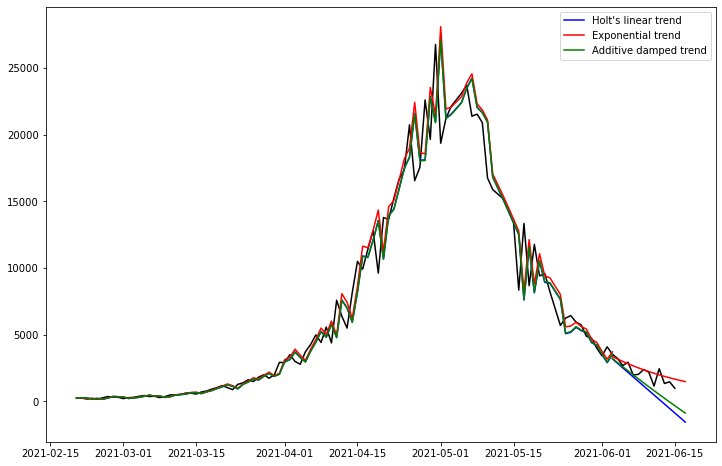

In [191]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings 
warnings.filterwarnings("ignore")

# daily_pos : Daily Covid Positive data for Bengaluru Urban
# Fitting Holt Techniques for different parameters(linear, exponential, additive damped) on Daily Covid Positives values
fit1 = Holt(daily_pos, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast1 = fit1.forecast(15).rename("Holt's linear trend")
fcast1.index = pd.date_range('2021-06-03','2021-06-17')

fit2 = Holt(daily_pos, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast2 = fit2.forecast(15).rename("Exponential trend")
fcast2.index = pd.date_range('2021-06-03','2021-06-17')

fit3 = Holt(daily_pos, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized = True)
fcast3 = fit3.forecast(15).rename("Additive damped trend")
fcast3.index = pd.date_range('2021-06-03','2021-06-17')

plt.figure(figsize=(12, 8))
line0, = plt.plot(data_new['Todays_Positives'].iloc[200:], color='black', label = 'Actual values')
plt.plot(fit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1, color='blue')
plt.plot(fit2.fittedvalues, color='red')
line2, = plt.plot(fcast2, color='red')
plt.plot(fit3.fittedvalues, color='green')
line3, = plt.plot(fcast3, color='green')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

Text(0.5, 1.0, 'ARIMA Predictions for next 15 days with 99% Confidence Interval')

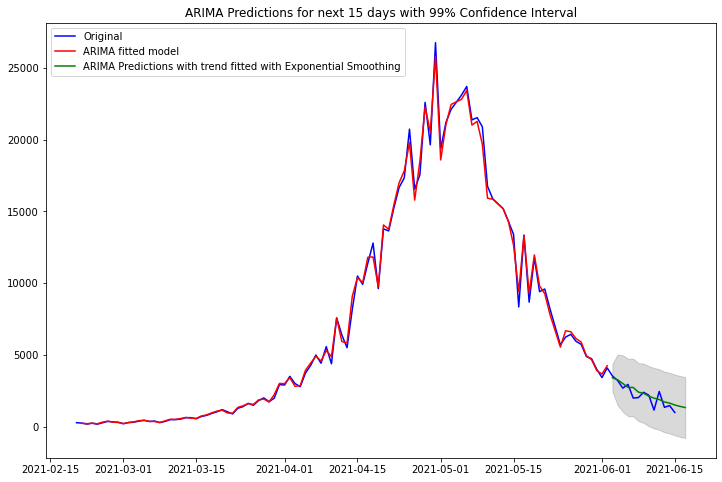

In [192]:
# Previously plotted data with Holt Exponential Smoothing and ARIMA only for comparison
figure(figsize=(12, 8))
plt.plot(data_new['Todays_Positives'].iloc[200:], color = 'blue',label = 'Original')
plt.plot(predictions_ARIMA_diff + trend + seasonal, color = 'red', label = 'ARIMA fitted model')
plt.plot(prediction_holt_exp_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with Exponential Smoothing')
plt.fill_between(prediction_holt_exp_15.index, prediction_holt_exp_15.low_conf, prediction_holt_exp_15.high_conf, 
                 color='k', alpha=.15)
plt.legend(loc = 'upper left')
plt.title('ARIMA Predictions for next 15 days with 99% Confidence Interval')

<h2> Comparing the Holt Exponential Smoothing Predictions, ARIMA and Holt ES on trend with actual value</h2>

In [193]:
from sklearn.metrics import mean_squared_error

RMSE for Actual and Only Holt Exponential Smoothing: 216184.60769686277

RMSE for Actual and ARIMA with Holt Exponential Smoothing trend: 178054.31225562296



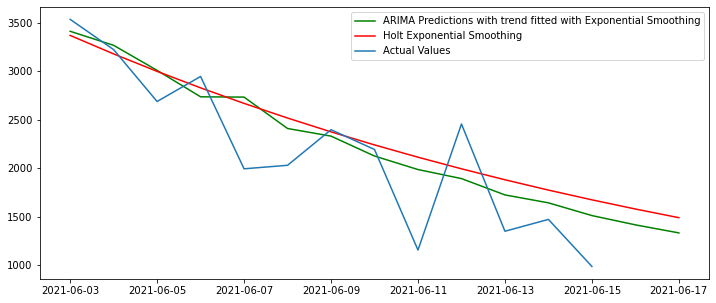

In [194]:
# We measure the forecast values by RMSE, for next 15 days between Holt ES on daily covid positive data, ARIMA on residues with trend fitted with Holt ES and Actual Observed Values

figure(figsize = (12,5))
plt.plot(prediction_holt_exp_15.forecast, color = 'green', label = 'ARIMA Predictions with trend fitted with Exponential Smoothing')
plt.plot(fcast2, color='red', label = 'Holt Exponential Smoothing')
plt.plot(data_new['Todays_Positives'].tail(13), label = 'Actual Values')
plt.legend(loc = 'upper right')
print(f"RMSE for Actual and Only Holt Exponential Smoothing: {mean_squared_error(data_new['Todays_Positives'].tail(13).values, fcast2.head(13).values)}\n")
print(f"RMSE for Actual and ARIMA with Holt Exponential Smoothing trend: {mean_squared_error(data_new['Todays_Positives'].tail(13).values, prediction_holt_exp_15.forecast.head(13).values)}\n")